C:\Users\Ananasy\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


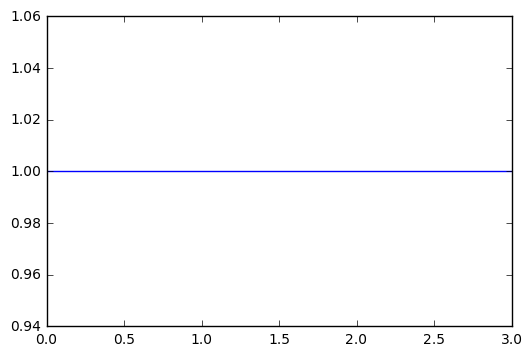

Optimal regularization coefficient:0.0001


0.921251348436


0.74213836478


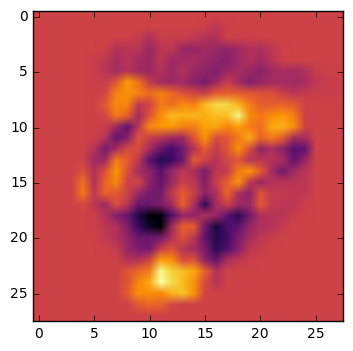

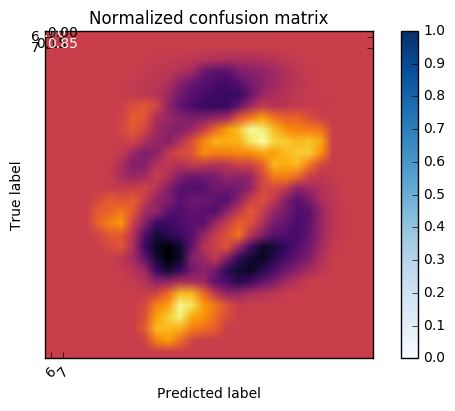

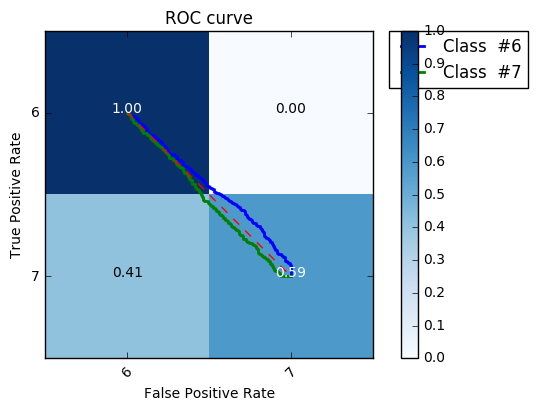

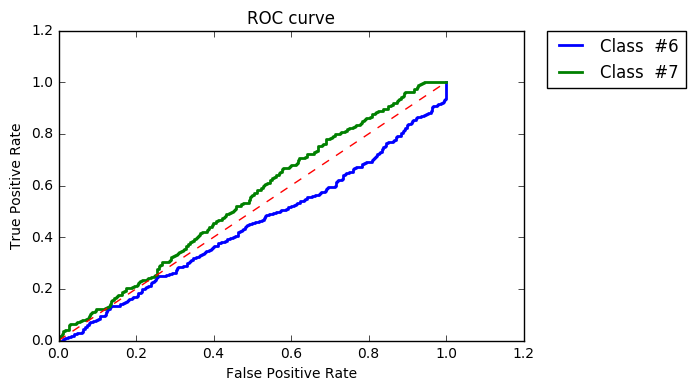

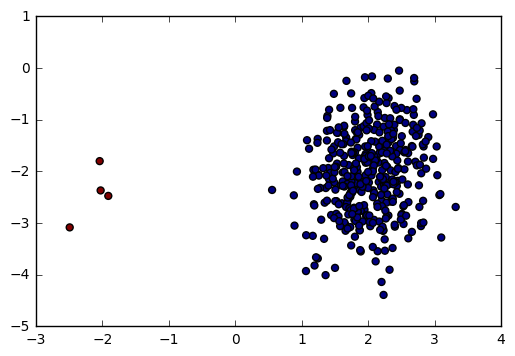

0.320675105485


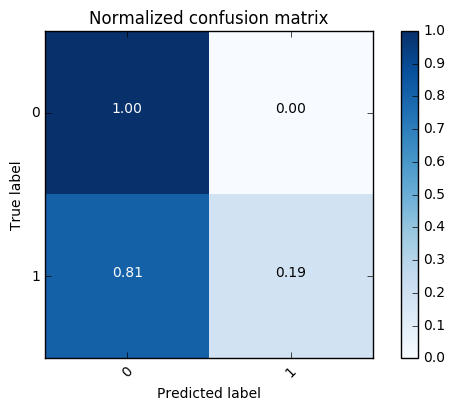

C:\Users\Ananasy\Anaconda3\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Users\Ananasy\Anaconda3\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


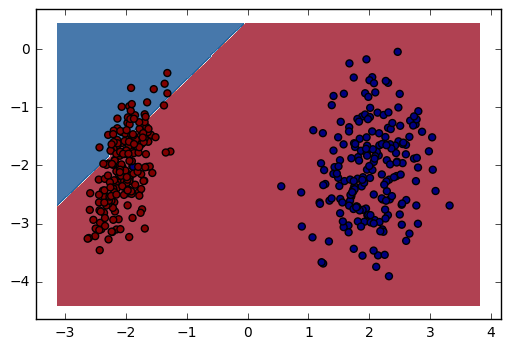

[-0.32870464  0.09406519]
[-73.1313114    4.07944474]
Difference rate:  0.990936662456
Persentage of gradient match:  0.94


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
import scipy.io
import random
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import itertools
from scipy.linalg import norm
import os

# uploading data
MNIST = scipy.io.loadmat(os.path.join(os.getcwd(), 'task_2', 'sub_task_2', 'data_MNIST.mat'))
Xtrain = MNIST['Xtrain']
Ytrain = MNIST['ytrain']
Xtest = MNIST['Xtest']
Ytest = MNIST['ytest']


def generate_data(X, Y, used_num=(0, 1), percentage=0.5, count=100, rand=False):
    count_num = [0, 0]
    count_num_lim = [int(count*percentage), int(count*(1-percentage))]
    Map = []
    Classes = []
    if not rand:
        for x_i in range(len(X)):
            if Y[x_i, 0] in used_num:
                index = used_num.index(Y[x_i, 0])
                if count_num[index] < count_num_lim[index]:
                    count_num[index] += 1
                    Map.append(X[x_i])
                    Classes.append(Y[x_i, 0])
    else:
        indexes = [i for i in range(len(X))]
        random.shuffle(indexes)
        for x_i in range(len(X)):
            if Y[indexes[x_i], 0] in used_num:
                index = used_num.index(Y[indexes[x_i], 0])
                if count_num[index] < count_num_lim[index]:
                    count_num[index] += 1
                    Map.append(X[indexes[x_i]])
                    Classes.append(Y[indexes[x_i], 0])
    return np.array(Map), np.array(Classes, dtype=int)


def get_class_map(X, Y, targetClass):
    Map = []
    for x_i in range(len(X)):
        if Y[x_i] == targetClass:
            Map.append(X[x_i])
    return np.array(Map)


def normalize(Y, c):
    ind1 = np.where(Y == c[0])
    ind2 = np.where(Y == c[1])
    Y[ind1] = -1
    Y[ind2] = 1


def get_psi(X, y):
    return 0.5*np.dot(y.T, X)


def predict_class(W, x, p=False):
    v = np.dot(W, x.T)
    if p:
        W = np.delete(W, -1, 1)
        plt.imshow(np.reshape(W, (28, 28)), cmap='inferno')
    for i in range(x.shape[0]):
        if v[0, i] >= 0:
            v[0, i] = 1
        else:
            v[0, i] = 0
    return v.T.astype(int)


# get index array
def filtr(X, y, c=1):
    x = np.argsort(X, axis=1)[0]
    f = np.where(y == c)
    result = []
    for t in x:
        if t in f[0]:
            result.append(t)
    return result


# f-score
def f_score(a, b, c, d):
    if a == 0:
        return 0
    pr = a/(a+b)
    rec = a/(b+d)
    return 2*(pr*rec)/(pr+rec)


def loss_augmented_decoding(x, W, y):
    N, dim = x.shape[0], x.shape[1]
    scores = np.dot(x, W.T).T
    result = y
    pos = filtr(scores, y, 1)
    neg = filtr(scores, y, -1)
    ys = predict_class(W, x)
    u, P, N = 0, len(pos), len(neg)
    for i in range(P * N):
        a, d = i // N, i % N
        c, b = P - a, N - d
        ys[pos[:a]], ys[pos[a:]] = 1, -1
        ys[neg[:b]], ys[neg[b:]] = 1, -1
        delta = 1 - f_score(a, b, c, d)
        var = np.dot(get_psi(x, ys) - get_psi(x, y), W.T)[0][0]
        u_ = delta + var
        if u_ > u:
            u = u_
            result = np.copy(ys)

    return result


def approx_grad(f, x0, eps=1e-5):
    epsilon = eps
    dim = x0.shape[1]
    grad = np.zeros((1, dim))
    e = np.zeros((1, dim))
    for k in range(dim):
        e[0, k] = epsilon
        grad[0, k] = (f(x0 + e) - f(x0))/epsilon
        e[0, k] = 0
    return grad


def risk_emp(W, X, y, lmbda):
    K = 2
    N, dim = X.shape[0], X.shape[1]
    data = False
    # loss-augmented decoding (separation oracle)
    y_hat = loss_augmented_decoding(X, W, y)
    delta = 1-f1_score(y, y_hat)
    # gradient
    dpsi = get_psi(X, y_hat)-get_psi(X, y)
    grad_W = lmbda*W+dpsi
    par1 = 0.5*lmbda*np.sum(np.dot(W, W.T))
    par2 = delta
    par3 = np.dot(dpsi, W.T)[0][0]
    risk = par1+(par2+par3)/N
    if data and (par2+par3 != 0):
            plt.figure()
            plt.imshow(np.reshape(np.delete(dpsi, -1, 1), (28, 28)), cmap='inferno')
    return risk, grad_W


def grdient(objective, x_init, stepsize=0.04, max_iter=1000, data=False):
    x = x_init
    f_pred = 0
    for i in range(max_iter):
        f_val, gradient = objective(x)
        '''if f_val<0:
            break'''
        delta = stepsize*gradient
        x = x - delta
        if data:
            plt.figure()
            plt.imshow(np.reshape(np.delete(delta, -1, 1), (28, 28)), cmap='inferno')
        d_risk = abs(f_pred-f_val)
        #print('Iteration:{}\trisk:{}\tdelta_risk:{}\tdelta:{} '.format(i, f_val, d_risk, norm(delta)))
        if d_risk < stepsize*1e-3:
            break
        f_pred = f_val
    return x


def train_data(X_train, Y_train, lmbda=0.01, step_size=0.05):
    dim = X_train.shape[1]
    objective = lambda w: risk_emp(w, X_train, Y_train, lmbda)
    w_init = np.zeros((1, dim))
    W_opt = grdient(objective, w_init, step_size, max_iter=200)
    return W_opt


# get coef for ROC-curve
def count_classes(predict, test, classes):
    pluses = [0 for i in range(len(classes))]
    minuses = [0 for i in range(len(classes))]
    for i in range(len(classes)):
        for j in range(len(predict)):
            if test[j] == predict[j] and test[j] == i:
                pluses[i] += 1
            else:
                minuses[i] += 1
    return pluses, minuses


# ROC-curve
def ROC(predict, test, classes):
    pluses, minuses = count_classes(predict, test, classes)
    fpr = np.zeros((predict.shape[0]+1, 2))
    tpr = np.zeros((predict.shape[0]+1, 2))
    for k in range(len(classes)):
        for i in range(1, predict.shape[0]+1):
            if predict[i-1] == test[i-1] and test[i-1] == k:
                fpr[i, k] = fpr[i-1, k]
                tpr[i, k] = tpr[i-1, k]+1/pluses[k]
            else:
                fpr[i, k] = fpr[i-1, k]+1/minuses[k]
                tpr[i, k] = tpr[i-1, k]

    for i in range(len(classes)):
        plt.plot(fpr[:, i], tpr[:, i], lw=2, label='Class  #{}'.format(classes[i]))
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# parameters
classes = [6, 7]
TrainSize = 400
TestSize = 1000
TestProportion = 0.5


# train and test data
X_train, Y_train = generate_data(Xtrain, Ytrain, classes, 0.99, TrainSize, True)
Y_train = Y_train.reshape((Y_train.shape[0], 1))
X_train = np.c_[X_train, np.ones((TrainSize,))]
X_test, Y_test = generate_data(Xtest, Ytest, classes, TestProportion, TestSize, True)
Y_test = Y_test.reshape((Y_test.shape[0], 1))
X_test = np.c_[X_test, np.ones((TestSize,))]

normalize(Y_train, classes)
Y_test[np.where(Y_test == classes[0])] = 0
Y_test[np.where(Y_test == classes[1])] = 1

# cross-validation
Y_test[np.where(Y_test == classes[1])] = 1
E_cv = []
min_l = np.inf
min_err = np.inf
for lmbda in [1e-4, 1e-3, 0.01, 0.1]:
    print('lambda={}      '.format(lmbda), end='\r')
    y_pred = predict_class(train_data(X_train, Y_train, lmbda), X_test)
    if y_pred.shape == Y_test.shape:
        err = 1 - f1_score(y_pred, Y_test)
        if err < min_err:
            min_err = err
            min_l = lmbda
        E_cv.append(err)

plt.plot(E_cv)
plt.show()

print('Optimal regularization coefficient:{}'.format(min_l))


# Training SVM
XS = np.delete(X_train, -1, 1)
model = LinearSVC(random_state=0)
model.fit(XS, Y_train.ravel())


# Comparing classifiers with F-score
XT = np.delete(X_test, -1, 1)
predictedClasses = model.predict(XT)
plt.imshow(np.reshape(model.coef_, (28, 28)), cmap='inferno')
predictedClasses[np.where(predictedClasses == -1)] = 0
predictedClasses[np.where(predictedClasses == 1)] = 1
print(f1_score(Y_test, predictedClasses))
plt.figure()
cms = confusion_matrix(Y_test, predictedClasses)
plot_confusion_matrix(cms, classes=classes, normalize=True,
                      title='Normalized confusion matrix')


W = train_data(X_train, Y_train, 10, 0.01)
y_pred = predict_class(W, X_test, True)
print(f1_score(Y_test, y_pred))
plt.figure()
cmm = confusion_matrix(Y_test, y_pred)
plot_confusion_matrix(cmm, classes=classes, normalize=True,
                      title='Normalized confusion matrix')


# ROC-curves
ROC(y_pred, Y_test, classes)
ROC(predictedClasses, Y_test, classes)


##############################################
# Train test split
K = 2  # number of classes
trSize = 400
tstSize = 400
R = 10
Prop = 0.99
x_tr, y_tr = make_classification(n_samples=trSize, n_features=2, class_sep=2,
                           n_redundant=0, n_informative=2,
                              n_clusters_per_class=1, n_classes=K, random_state=R,weights=[Prop, 1-Prop])

x_tst, y_tst = make_classification(n_samples=tstSize, n_features=2, class_sep=2,
                           n_redundant=0, n_informative=2,
                              n_clusters_per_class=1, n_classes=K, random_state=R,weights=[0.5, 0.5])
x_tr = np.c_[x_tr, np.ones((trSize,))]
x_tst = np.c_[x_tst, np.ones((tstSize,))]
normalize(y_tr, np.unique(y_tr))
plt.scatter(x_tr[:, 0], x_tr[:, 1], marker='o', c=y_tr, s=25, edgecolor='k')
plt.show()
y_tr = np.array(y_tr).reshape((Y_train.shape[0], 1))


##
w = train_data(x_tr, y_tr, 0.01, 0.01)
y_pred = predict_class(w, x_tst)
print(f1_score(y_tst, y_pred))

plt.figure()
cms = confusion_matrix(y_tst,y_pred)
plot_confusion_matrix(cms, classes=np.unique(Y_test), normalize=True,
                      title='Normalized confusion matrix')
plt.show()
h = .02  # step size in the mesh
x_min, x_max = x_tst[:, 0].min() - .5, x_tst[:, 0].max() + .5
y_min, y_max = x_tst[:, 1].min() - .5, x_tst[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

X_test = np.c_[xx.ravel(), yy.ravel(), np.ones((xx.size,))]
y_pred = predict_class(w, X_test)

Z = y_pred.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.8)
plt.scatter(x_tst[:, 0], x_tst[:, 1], marker='o', c=y_tst, s=25, edgecolor='k')
plt.show()


##################
N = 100
dim = 2
x = np.random.randn(N, dim)
w = np.zeros((1, dim))
y = np.zeros((N, 1)).astype(int)
for i in range(N):
    if x[i][0] < 0:
        y[i, 0] = -1
    else:
        y[i, 0] = 1

# compare gradient
func = lambda w: risk_emp(w, x, y, lmbda)[0]
gradient = lambda w: risk_emp(w, x, y, lmbda)[1]

numerical_gradient = approx_grad(func, w, 1e-7)
analytical_gradient = gradient(w)
print(numerical_gradient[0])
print(analytical_gradient[0])

diff = norm(numerical_gradient - analytical_gradient)/norm(numerical_gradient + analytical_gradient)
print('Difference rate: ', diff)
print('Persentage of gradient match: ', accuracy_score(predict_class(analytical_gradient, x).T[0],
                                                       predict_class(numerical_gradient, x).T[0]))